In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
brain_df = pd.read_csv('D:\\brain_tumor\\kaggle_3m\\data.csv')

In [3]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
brain_df.head(5)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [5]:
import glob
import os

In [ ]:
data_map = []
for sub_dir_path in glob.glob("D:\\brain_tumor\\seg_data\\*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])

df = pd.DataFrame({
    "patient_id" : data_map[::2],
    "path" : data_map[1::2]
})

df

,patient_id,path
0,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...
1,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...
2,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...
3,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...
4,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...
...,...,...
3663,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...
3664,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...
3665,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...
3666,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...


In [7]:
df_images = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN =68
END_IMG_LEN = 4
END_MASK_LEN = 9
# data = []

images = sorted(df_images["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))
# patient = for i in data: print(i)

df_brain = pd.DataFrame({
    "patient_id": df_images.patient_id.values,
    "image_path": images,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    return 0

df_brain["mask"] = df_brain["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

df_brain

,patient_id,image_path,mask_path,mask
0,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909/...,0
1,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4942_19970222/...,D:\brain_tumor\seg_data\TCGA_CS_4942_19970222/...,0
2,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4943_20000902/...,D:\brain_tumor\seg_data\TCGA_CS_4943_20000902/...,0
3,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_4944_20010208/...,D:\brain_tumor\seg_data\TCGA_CS_4944_20010208/...,0
4,D:\brain_tumor\seg_data\TCGA_CS_4941_19960909,D:\brain_tumor\seg_data\TCGA_CS_5393_19990606/...,D:\brain_tumor\seg_data\TCGA_CS_5393_19990606/...,0
...,...,...,...,...
1829,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,0
1830,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,0
1831,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,0
1832,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,0


In [8]:
# data = []
# for i in range(len(df_images.patient_id.values)):
#     data.append(df_images.patient_id.values[i][25:])
# #     print(df_images.patient_id.values[i][25:])

In [9]:
df_brain['mask'].value_counts()

0    1222
1     612
Name: mask, dtype: int64

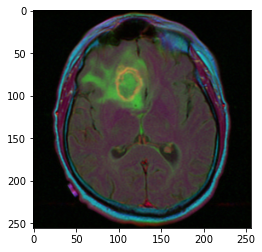

In [10]:
image = cv2.imread(df_brain.image_path[600])
plt.imshow(image)

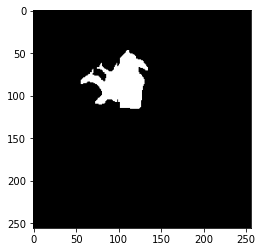

In [11]:
image1 = cv2.imread(df_brain.mask_path[600])
plt.imshow(image1)

In [12]:
cv2.imread(df_brain.mask_path[600]).max()

255

In [13]:
classes = np.unique(cv2.imread(df_brain.mask_path[600],cv2.IMREAD_GRAYSCALE))

In [14]:
print('Number of classes:', len(classes))

Number of classes: 2


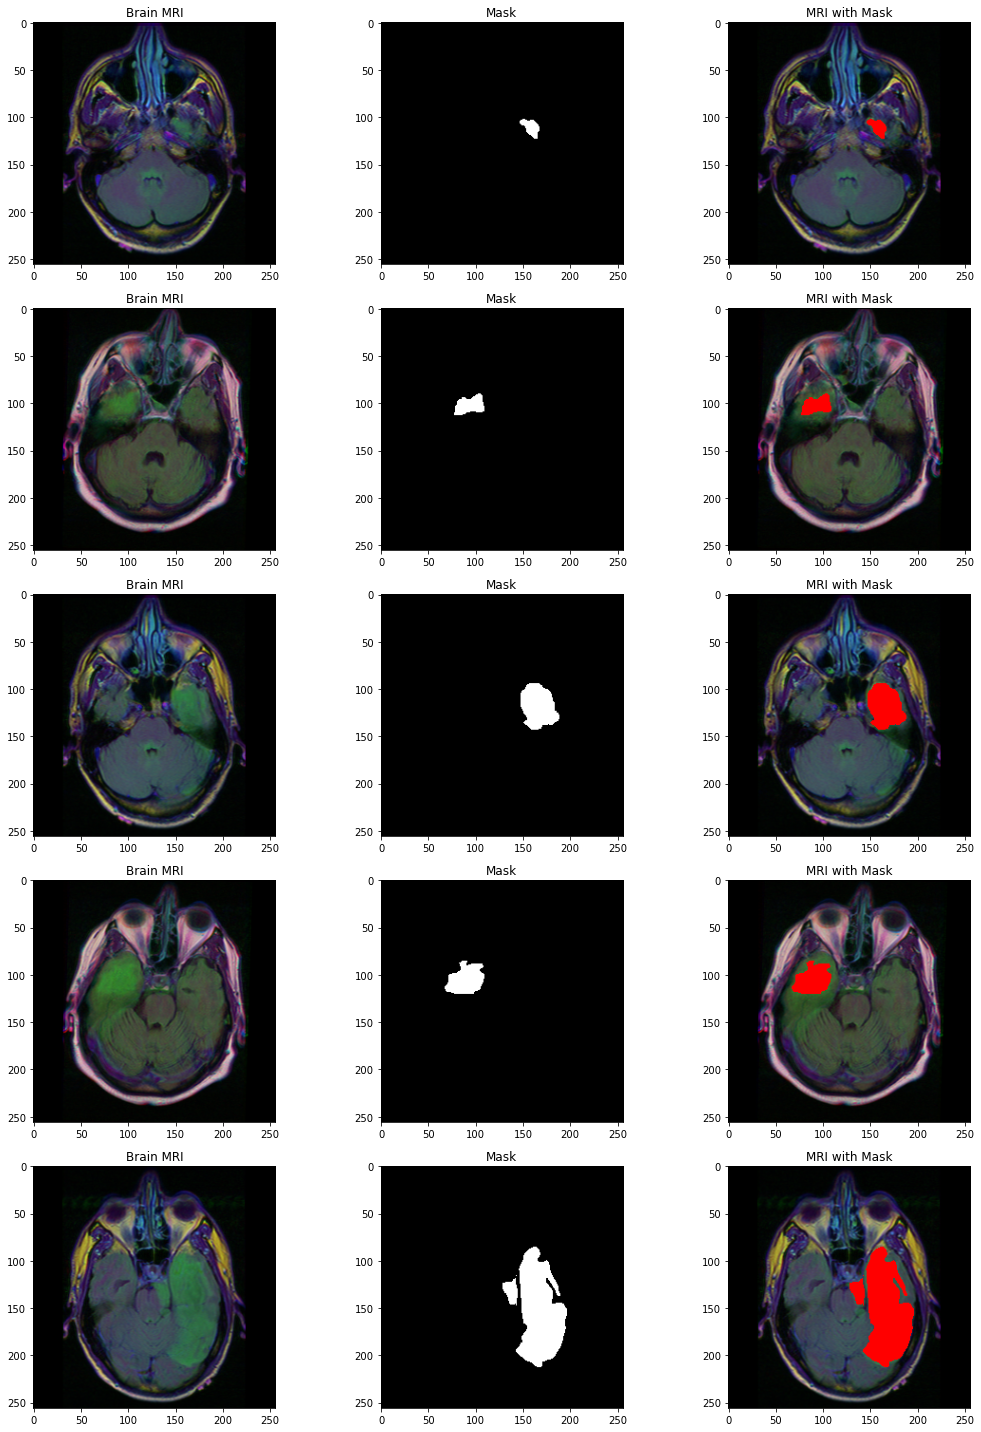

In [15]:
count = 0
fig, axs = plt.subplots(5, 3, figsize = (15, 20))
for i in range(len(df_brain)):
  if df_brain['mask'][i] ==1 and count <5:
    img = io.imread(df_brain.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)
    
    mask = io.imread(df_brain.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')
    
    img[mask == 255] = (255, 0, 0) #Red color
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

In [16]:
brain_df_mask = df_brain[df_brain['mask'] == 1]
brain_df_mask.shape

(612, 4)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [18]:
X_test

,patient_id,image_path,mask_path,mask
721,D:\brain_tumor\seg_data\TCGA_DU_6399_19830416,D:\brain_tumor\seg_data\TCGA_DU_5855_19951217/...,D:\brain_tumor\seg_data\TCGA_DU_5855_19951217/...,1
1042,D:\brain_tumor\seg_data\TCGA_DU_6407_19860514,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...,1
1629,D:\brain_tumor\seg_data\TCGA_DU_7304_19930325,D:\brain_tumor\seg_data\TCGA_DU_7010_19860307/...,D:\brain_tumor\seg_data\TCGA_DU_7010_19860307/...,1
1720,D:\brain_tumor\seg_data\TCGA_DU_7309_19960831,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,1
737,D:\brain_tumor\seg_data\TCGA_DU_6399_19830416,D:\brain_tumor\seg_data\TCGA_DU_7019_19940908/...,D:\brain_tumor\seg_data\TCGA_DU_7019_19940908/...,1
1319,D:\brain_tumor\seg_data\TCGA_DU_7014_19860618,D:\brain_tumor\seg_data\TCGA_DU_6404_19850629/...,D:\brain_tumor\seg_data\TCGA_DU_6404_19850629/...,1
1392,D:\brain_tumor\seg_data\TCGA_DU_7019_19940908,D:\brain_tumor\seg_data\TCGA_DU_7014_19860618/...,D:\brain_tumor\seg_data\TCGA_DU_7014_19860618/...,1
806,D:\brain_tumor\seg_data\TCGA_DU_6400_19830518,D:\brain_tumor\seg_data\TCGA_CS_5396_20010302/...,D:\brain_tumor\seg_data\TCGA_CS_5396_20010302/...,1
307,D:\brain_tumor\seg_data\TCGA_CS_6667_20011105,D:\brain_tumor\seg_data\TCGA_CS_5397_20010315/...,D:\brain_tumor\seg_data\TCGA_CS_5397_20010315/...,1
1228,D:\brain_tumor\seg_data\TCGA_DU_7013_19860523,D:\brain_tumor\seg_data\TCGA_DU_7294_19890104/...,D:\brain_tumor\seg_data\TCGA_DU_7294_19890104/...,1


In [19]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [20]:
len(train_ids) , len(train_mask) , len(val_ids),len(val_mask)

(520, 520, 46, 46)

In [21]:
import keras
from sklearn.preprocessing import LabelEncoder

In [22]:
def DataGenerator(img , mask):  
    
    emp = []
    for i in img:
        image = cv2.imread(i)
        emp.append(image)
#     print(len(emp))
    
    masks = []
    for j in mask:
        image = cv2.imread(j)
        masks.append(image)
#     print(len(masks))


    X = np.array(emp , dtype ='float') / 255.0
    y = np.array(masks , dtype = 'float') / 255.0
    
    print(y.shape)
#     print(y)
    
    masks = y[:, :, :, 0]
    
#     print(masks.shape)
#     print(masks)
#     print(y)
    

#     y = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y))
    y = keras.utils.to_categorical(masks,2, dtype ='float32')
#     y = np.squeeze(y , axis=2)
#     print(X)
#     print(y.shape)
    
    return X , y  

In [23]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

(520, 256, 256, 3)
(46, 256, 256, 3)


In [24]:
# val_y

In [25]:
X , y = training_generator
val_X , val_y = validation_generator

In [26]:
val_y.shape

(46, 256, 256, 2)

In [27]:
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# img_arrs = []
# mask_arrs = []
# ids = []

# def test_data_generator(test_df, image_size):
#     for _, row in test_df.iterrows():
#         img = load_img(row['image_path'], target_size=image_size)
#         img_arr = img_to_array(img) / 255.0
#         img_arrs.append(img_arr)
#         mask = load_img(row['mask_path'], target_size=image_size, color_mode='grayscale')
#         mask_arr = img_to_array(mask) / 255.0
#         mask_arr = np.expand_dims(mask_arr, axis=-1)
#         ids.append(row['image_path'])
#         mask_arrs.append(row['mask_path'])
#     return img_arrs , ids , mask_arrs #, mask_arr, row['patient_id'], row['mask']

In [28]:
# img_arrs = []

# for _,row in X_test.iterrows():
#     img = load_img(row['image_path'], target_size=(256 , 256 , 3))
#     img_arr = img_to_array(img) / 255.0
#     img_arrs.append(img_arr)

# print(len(img_arrs) , row[''])
    

In [29]:
test = test_data_generator(X_test , (256 , 256 , 3))

In [30]:
test

([array([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]], dtype=f

In [31]:
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [32]:
def resblock(X, f):

  # make a copy of input
  X_copy = X

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [33]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [34]:

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(2, (1,1), padding = "same", activation = "sigmoid")(up_4)

model = Model(inputs = X_input, outputs = output )


In [35]:
# class network(tf.keras.Model):
    
#     def __init__(self,model,loss,metric,loss_weights):
#         super().__init__()
#         self.loss = loss
#         self.metric = metric
#         self.model = model
#         self.loss_weights = loss_weights

In [36]:
# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

In [37]:
# from tensorflow.keras.losses import BinaryCrossentropy

In [38]:
# model = network(model,BinaryCrossentropy(),dice_coef,[1,0.5])

In [39]:
model.compile(optimizer=adam,loss=BinaryCrossentropy(),metrics=[dice_coef])

In [40]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [41]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [42]:
checkpointer = ModelCheckpoint(filepath="ResUNet-new-weights.hdf5", verbose=1, save_best_only=True)
history = model.fit(X , y, epochs=100,validation_data = (val_X , val_y), callbacks = [checkpointer, earlystopping])

# model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [43]:
from keras.models import load_model
model = load_model('ResUNet-new-weights.hdf5' , custom_objects={'focal_tversky': focal_tversky , 'tversky' : tversky })

In [76]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [44]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [45]:
img , ids , mask = test

In [46]:
len(img) , len(ids)

(46, 46)

In [47]:
import numpy as np
import pandas as pd

def prediction(image ,ids , mask ,  seg_model):
    
#     print(len(img))

    mask_preds = []

    for i in image:
        image = np.expand_dims(i, axis=0)
        
#         print(image.shape)

        # Make segmentation prediction
        seg_pred = seg_model.predict(image)
        mask_pred = np.argmax(seg_pred, axis=-1)
        mask_pred = np.squeeze(mask_pred)

        # Add to lists
#         image_ids.append(ids)
        mask_preds.append(mask_pred)

    # Convert to DataFrame
    predictions = pd.DataFrame({
        'Image_Id': ids,
        'mask_id' : mask,
        'Mask': mask_preds
    })

    return predictions


In [48]:
df_pred = prediction(img, ids, mask , model)

In [49]:
df_pred.head()

,Image_Id,mask_id,Mask
0,D:\brain_tumor\seg_data\TCGA_DU_5855_19951217/...,D:\brain_tumor\seg_data\TCGA_DU_5855_19951217/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...,D:\brain_tumor\seg_data\TCGA_DU_8164_19970111/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,D:\brain_tumor\seg_data\TCGA_DU_7010_19860307/...,D:\brain_tumor\seg_data\TCGA_DU_7010_19860307/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,D:\brain_tumor\seg_data\TCGA_DU_5872_19950223/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,D:\brain_tumor\seg_data\TCGA_DU_7019_19940908/...,D:\brain_tumor\seg_data\TCGA_DU_7019_19940908/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [50]:
len(df_pred)

46

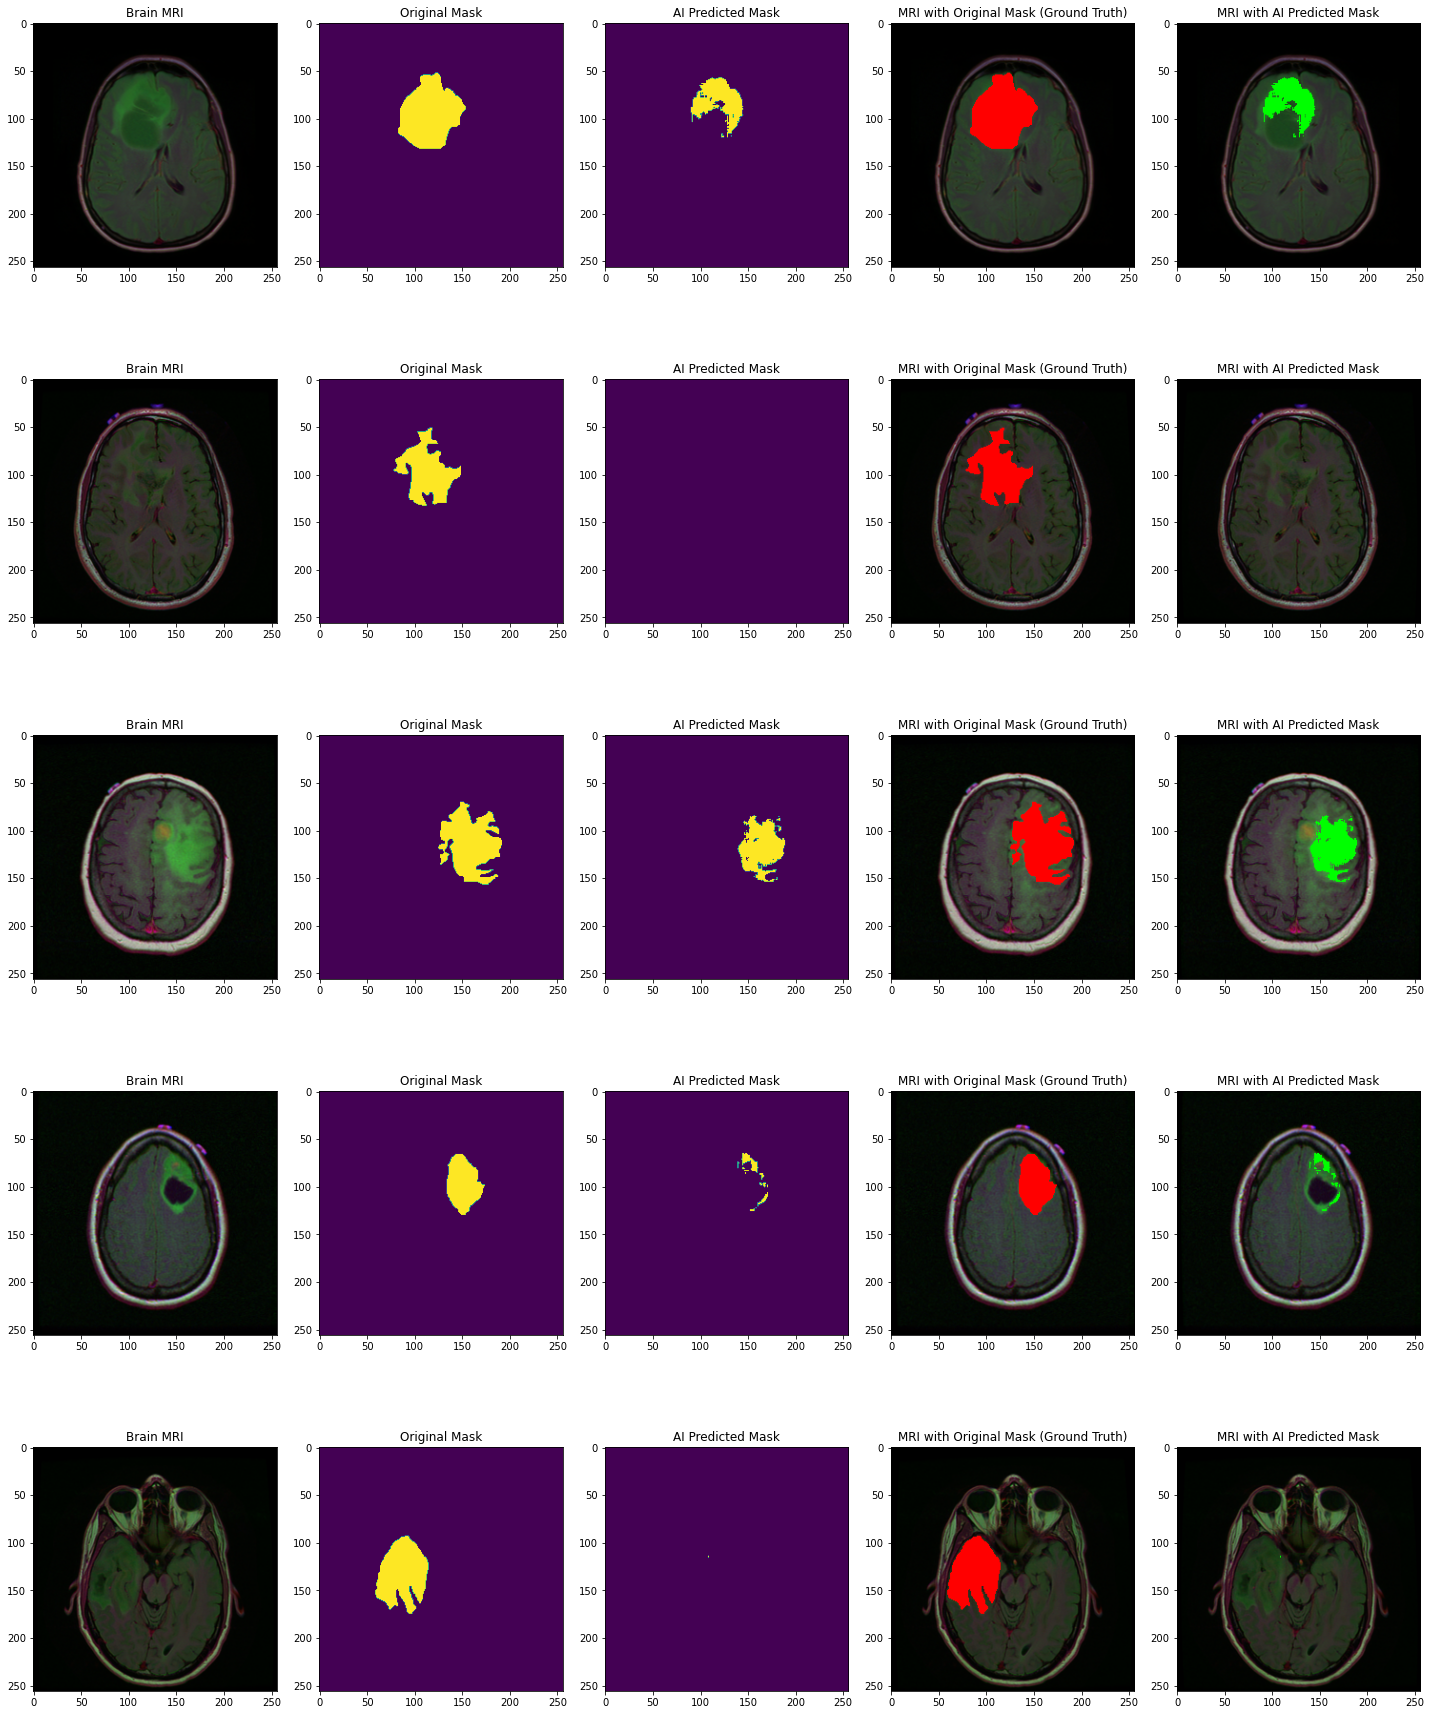

In [51]:
count = 0
fig, axs = plt.subplots(5, 5, figsize=(20, 25))
for i in range(0,len(df_pred.head())):
    img = io.imread(df_pred.Image_Id[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].set_title("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_id[i])
#     print(mask.shape)
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.Mask[i])
#     print(predicted_mask.shape)
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.Image_Id[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

In [52]:
# from keras.models import load_model
# model = load_model('ResUNet-new-weights.hdf5' , custom_objects={'focal_tversky': focal_tversky , 'tversky' : tversky })

In [53]:
# model.summary()

In [54]:
# model.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [55]:
model.evaluate(val_X, val_y, verbose=0)

[0.03109065815806389, 0.9902210235595703]

In [59]:
predictions = model.predict(val_X)

In [60]:
predictions

array([[[[9.99954462e-01, 2.84820795e-04],
         [9.99963105e-01, 3.38703394e-04],
         [9.99965191e-01, 2.39104033e-04],
         ...,
         [9.99927521e-01, 4.71472740e-04],
         [9.99943972e-01, 4.61786985e-04],
         [9.99978662e-01, 2.92867422e-04]],

        [[9.99938726e-01, 1.92314386e-04],
         [9.99961495e-01, 6.60364749e-05],
         [9.99974012e-01, 5.09458841e-05],
         ...,
         [9.99948919e-01, 1.35958195e-04],
         [9.99965966e-01, 1.00721169e-04],
         [9.99970436e-01, 1.51336193e-04]],

        [[9.99940038e-01, 3.63439322e-04],
         [9.99965370e-01, 9.94431684e-05],
         [9.99975204e-01, 6.59449724e-05],
         ...,
         [9.99968112e-01, 8.90083538e-05],
         [9.99966741e-01, 8.90555675e-05],
         [9.99975562e-01, 9.93078283e-05]],

        ...,

        [[9.99902129e-01, 1.43736601e-04],
         [9.99898314e-01, 1.26898289e-04],
         [9.99942183e-01, 9.14347620e-05],
         ...,
         [9.99963999e